In [20]:
import json

import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
with open('/home/lq/Research/Reading-Comprehension/les-military-mrc/les_mrc/span_mrc/bridge_entity_models/bridge_entity_mrc_BertForLes_no-bridge-entity_back-trans_0928/null_odds_les.json') as f:
    dev_entity_null_score_diff = json.load(f)
  

In [3]:
ans_pattern = re.compile(r'@content\d@')


def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return list(set([int(doc[-2:-1]) for doc in docs]))


In [4]:
train_sample_has_entity = {}
train_sample_has_entity_fulldocs = {}

with open('../input/bridge_entity_mrc_dataset/train_max_content_len_1024.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        support_para_in_docids = find_answer_in_docid(sample['supporting_paragraph'])
        
        if sample['bridging_entity'] is None or len(sample['bridging_entity'].strip()) == 0:
            train_sample_has_entity_fulldocs[sample['question_id']] = False
        else:
            train_sample_has_entity_fulldocs[sample['question_id']] = True
        
        if sample['bridging_entity'] is None or len(sample['bridging_entity'].strip()) == 0:
            for doc_i, doc in enumerate(sample['documents']):
                train_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False
        else:
            for sup_doc_i in support_para_in_docids:
                if sample['bridging_entity'] in sample['documents'][sup_doc_i-1]['content']:
                    train_sample_has_entity['{}##{}##0'.format(sample['question_id'], sup_doc_i-1)] = True
            
            for doc_i, doc in enumerate(sample['documents']):
                if doc_i not in support_para_in_docids:
                    train_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False
                else:
                    if sample['bridging_entity'] in doc['content']:
                        train_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = True
                    else:
                        train_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False        

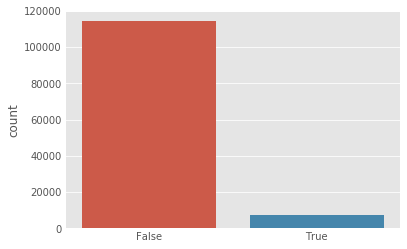

In [5]:
sns.countplot(list(train_sample_has_entity.values()))

In [6]:
sum(train_sample_has_entity.values()) / len(train_sample_has_entity)

0.06033115575824808

In [7]:
sum(train_sample_has_entity_fulldocs.values()) / len(train_sample_has_entity_fulldocs)

0.3644356793623403

In [8]:
dev_sample_has_entity = {}
dev_sample_has_entity_fulldocs = {}
with open('../input/bridge_entity_mrc_dataset/dev.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        support_para_in_docids = find_answer_in_docid(sample['supporting_paragraph'])
        
        if sample['bridging_entity'] is None or len(sample['bridging_entity'].strip()) == 0:
            dev_sample_has_entity_fulldocs[sample['question_id']] = False
        else:
            dev_sample_has_entity_fulldocs[sample['question_id']] = True
        
        if sample['bridging_entity'] is None or len(sample['bridging_entity'].strip()) == 0:
            for doc_i, doc in enumerate(sample['documents']):
                dev_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False
        else:
            for sup_doc_i in support_para_in_docids:
                if sample['bridging_entity'] in sample['documents'][sup_doc_i-1]['content']:
                    dev_sample_has_entity['{}##{}##0'.format(sample['question_id'], sup_doc_i-1)] = True
            
            for doc_i, doc in enumerate(sample['documents']):
                if doc_i not in support_para_in_docids:
                    dev_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False
                else:
                    if sample['bridging_entity'] in doc['content']:
                        dev_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = True
                    else:
                        dev_sample_has_entity['{}##{}##0'.format(sample['question_id'], doc_i)] = False        

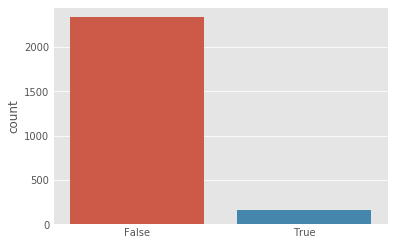

In [9]:
sns.countplot(list(dev_sample_has_entity.values()))

In [10]:
sum(dev_sample_has_entity.values()) / len(dev_sample_has_entity)

0.0656

In [11]:
sum(dev_sample_has_entity_fulldocs.values()) / len(dev_sample_has_entity_fulldocs)

0.37

In [ ]:
sns.kdeplot(list(dev_entity_null_score_diff.values()))

In [ ]:
dev_null_scores = np.array(list(dev_entity_null_score_diff.values()))

In [ ]:
len(dev_null_scores[dev_null_scores > 23.5]) / len(dev_null_scores)

In [ ]:
dev_score_diff = pd.DataFrame({'question_id_doc_id': list(dev_entity_null_score_diff.keys()),
                               'score_diff': list(dev_entity_null_score_diff.values())})

dev_sample_no_entity_df = pd.DataFrame({'question_id_doc_id': list(dev_sample_has_entity.keys()),
                                        'has_entity': list(dev_sample_has_entity.values())})

In [ ]:
dev_score_diff = pd.merge(dev_score_diff, dev_sample_no_entity_df, on='question_id_doc_id')

In [ ]:
dev_score_diff.head()

In [ ]:
sns.kdeplot(dev_score_diff[dev_score_diff['has_entity'] == True]['score_diff'],label='has_entity')
sns.kdeplot(dev_score_diff[dev_score_diff['has_entity'] == False]['score_diff'],label='no_entity')
plt.xlabel('score diff')

In [ ]:
pred_no_entity = dev_score_diff[dev_score_diff['score_diff'] > 15]

pred_no_entity.shape[0] / len(dev_score_diff[dev_score_diff['has_entity'] == False]['score_diff'])